In [1]:
from data_loader import SliceDataLoader

slice_data_loader = SliceDataLoader(mode="zhilei",label="class")
slice_data_loader.prepare()

Prepared data:
 - Train: 2 slices
 - Val: 1 slices
 - Test: 1 slices


In [ ]:
from biological_model3 import BiologicalModel2
model = BiologicalModel2(slice_data_loader.train_slices)
model.fit()

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# i = 28
# slice_obj = slice_data_loader.fine_tune_test_slices[i]
# xyz = model.sample_slice_conditionally(slice_obj, int(len(slice_obj) * 1.5), alpha=20)

# Flip Y axis for vertical orientation
x_sampled, y_sampled = xyz[:, 0], -xyz[:, 1]
x_real,   y_real   = slice_obj.obsm["aligned_spatial"][:, 0], -slice_obj.obsm["aligned_spatial"][:, 1]

# ORIGINAL-only bounds (left panel)
x_real_min, x_real_max = x_real.min(), x_real.max()
y_real_min, y_real_max = y_real.min(), y_real.max()

# COMBINED bounds (original + sampled) (right panel)
x_all = np.concatenate([x_real, x_sampled])
y_all = np.concatenate([y_real, y_sampled])
x_combined_min, x_combined_max = x_all.min(), x_all.max()
y_combined_min, y_combined_max = y_all.min(), y_all.max()

fig, axes = plt.subplots(
    1, 2,
    figsize=(12, 6),
    gridspec_kw={"width_ratios": [1, 2]}
)

# ─── Left panel: Original only ────────────────────────────
axes[0].scatter(x_real, y_real, s=0.1, color="#6E9C72")
# move title up within the axes and add extra top margin
axes[0].set_title("Original", y=1.05)
axes[0].set_xlim([x_real_min, x_real_max])
axes[0].set_ylim([y_real_min, y_real_max])
axes[0].axis("off")
axes[0].set_aspect("equal")

# ─── Right panel: Original + Sampled ───────────────────────
axes[1].scatter(x_real, y_real, s=0.1, color="#6E9C72")
axes[1].scatter(x_sampled, y_sampled, s=0.1, color="#5E74A0")
axes[1].set_title("Regenerated", y=1.05)
axes[1].set_xlim([x_combined_min, x_combined_max])
axes[1].set_ylim([y_combined_min, y_combined_max])
axes[1].axis("off")
axes[1].set_aspect("equal")

# add horizontal space between subplots and make room at top
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, top=0.88)

plt.savefig(
    "slice_28_spaced_titles_final.png",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.05
)
plt.close()


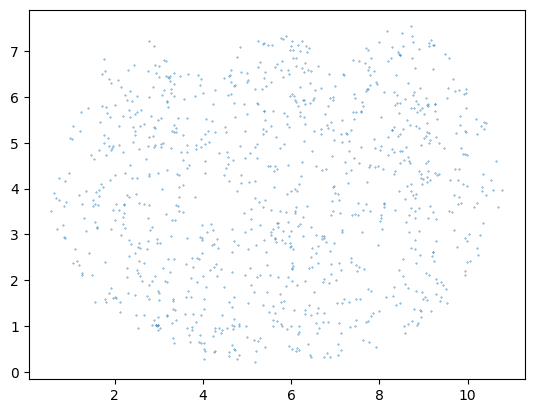

In [ ]:
plt.scatter(xyz[:,0],xyz[:,1],s=0.1)
plt.scatter(slice_data_loader.fine_tune_test_slices[i].obsm["aligned_spatial"][:,0],slice_data_loader.fine_tune_test_slices[i].obsm["aligned_spatial"][:,1],s=0.1)

In [3]:
# P(region|location)
from celltype_model8 import CelltypeModel

region_model = CelltypeModel(slice_data_loader.train_slices,slice_data_loader.gene_exp_model.num_tokens, val_slice=slice_data_loader.val_slices[0], epochs=500,learning_rate=0.001, batch_size=1024, device="cuda")

# region_model.fit()
region_model.load_model("best_model_zhilei.pt")

📦 Loaded model weights from best_model_zhilei.pt


In [4]:
import anndata as ad
from matplotlib.pyplot import rc_context
from metrics4 import *
from analysis import *

new_tissue=ad.concat(slice_data_loader.test_slices)
# ref_tissue=ad.concat(slice_data_loader.train_slices)#[slice_data_loader.train_slices[8],slice_data_loader.train_slices[9]])


device="cuda"
xyz_samples = torch.tensor(new_tissue.obsm["aligned_spatial"], dtype=torch.float32).to(device)
# adata_argmax, _ = generate_anndata_from_samples(region_model, xyz_samples, device, sample_from_probs=False, use_conditionals=True, xyz_labels=new_tissue.obs["token"],num_classes=region_model.x.shape[1]-3)
# adata_argmax, preds, probs = generate_anndata_from_samples(region_model, xyz_samples, device, sample_from_probs=False, use_conditionals=False, xyz_labels=new_tissue.obs["token"],num_classes=region_model.x.shape[1]-3,gibbs=False, n_iter=1, use_budget=False, graph_smooth=False)
adata_sampled, preds, probs = generate_anndata_from_samples(region_model, xyz_samples, device, sample_from_probs=True, use_conditionals=False, xyz_labels=new_tissue.obs["token"],num_classes=region_model.x.shape[1]-3,gibbs=False, n_iter=1, use_budget=False, graph_smooth=False)



/home/apdeshpa/projects/tissue-generator/analysis.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz_tensor = torch.tensor(xyz, dtype=torch.float32).to(device)


In [15]:
from analysis import *

ref_slice=ad.concat([slice_data_loader.train_slices[26],slice_data_loader.train_slices[28]])
adata_baseline_ct=generate_baseline1_majority(xyz_samples, ref_slice.obsm["aligned_spatial"], ref_slice.obs["token"],k=5)

In [8]:
import tqdm
import tqdm
import numpy as np
from scipy.spatial import cKDTree

def lookup_correlation(gt_celltypes, gt_positions, gt_expressions,
                       ref_celltypes, ref_positions, ref_expressions,
                       pred_celltypes, pred_positions, pred_exp,
                       radius=None, k=0, sample=None, ref_sample=None,
                       avg_k=20):
    """
    For each predicted cell, find the closest `avg_k` reference cells
    with the same celltype, and average their expressions.

    Arguments:
    - gt_*: ground-truth celltypes/positions/expressions for computing correlation
    - ref_*: reference celltypes/positions/expressions used for lookup
    - pred_*: predicted celltypes/positions (used for matching)
    """

    if ref_sample is not None:
        percent = ref_sample
        n = int(len(ref_positions) * percent / 100)
        indices = np.random.choice(len(ref_positions), size=n, replace=False)
        ref_celltypes = [ref_celltypes[i] for i in indices]
        ref_positions = [ref_positions[i] for i in indices]
        ref_expressions = ref_expressions[indices]

    ref_expressions = ref_expressions.todense().tolist()

    gt_positions = np.array(gt_positions)
    pred_positions = np.array(pred_positions)
    gt_expressions = np.array(gt_expressions)

    ref_positions = np.array(ref_positions)
    ref_expressions = np.array(ref_expressions)

    pred_expressions_lookup = np.zeros((len(pred_positions), ref_expressions.shape[1]))

    ref_by_type = {}
    for i, ct in enumerate(ref_celltypes):
        ref_by_type.setdefault(ct, []).append(i)

    for i, (ct, pos) in tqdm.tqdm(enumerate(list(zip(pred_celltypes, pred_positions)))):
        if ct not in ref_by_type:
            continue
        indices = ref_by_type[ct]
        ref_subset = ref_positions[indices]
        tree = cKDTree(ref_subset)

        k_query = min(avg_k, len(ref_subset))
        _, idxs = tree.query(pos, k=k_query)
        if k_query == 1:
            idxs = [idxs]

        selected_exps = [ref_expressions[indices[j]] for j in idxs]
        pred_expressions_lookup[i] = np.mean(selected_exps, axis=0)

    return soft_correlation(
        gt_expressions=gt_expressions,
        gt_positions=gt_positions,
        pred_expressions=pred_expressions_lookup,
        pred_positions=pred_positions,
        radius=radius,
        k=k,
        sample=sample
    )

#slice_data_loader.gene_exp_model.get_gene_exp_from_token(adata_sampled.obs["token"].tolist())
percent = 1
n = int(len(new_tissue) * percent / 100)
indices = np.random.choice(len(new_tissue), size=n, replace=False)
sampled_gt=new_tissue[indices]

percent = 10
n = int(len(adata_sampled) * percent / 100)
indices = np.random.choice(len(adata_sampled), size=n, replace=False)
adata_sampled_sampled=adata_sampled[indices]



lookup_correlation(sampled_gt.obs["token"].to_numpy().tolist(),sampled_gt.obsm["aligned_spatial"],sampled_gt.X.todense().tolist(),ref_tissue.obs["token"].to_numpy().tolist(),ref_tissue.obsm["aligned_spatial"],ref_tissue.X,adata_sampled_sampled.obs["token"].tolist(),adata_sampled_sampled.obsm["spatial"],None,k=20,ref_sample=1)

8045it [00:06, 1226.93it/s]
100%|██████████| 804/804 [00:00<00:00, 9315.78it/s]


0.8103384644044616

In [8]:
soft_correlation(new_tissue.X.todense().tolist(),new_tissue.obsm["aligned_spatial"],slice_data_loader.gene_exp_model.get_gene_exp_from_token(adata_argmax.obs["token"].tolist()),adata_argmax.obsm["spatial"],k=20, sample=1)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f26165c2500>>
Traceback (most recent call last):
  File "/home/apdeshpa/miniconda3/envs/torch_env_4_26/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
  File "_pydevd_bundle\\pydevd_cython.pyx", line 1697, in _pydevd_bundle.pydevd_cython.SafeCallWrapper.__call__
  File "_pydevd_bundle\\pydevd_cython.pyx", line 2017, in _pydevd_bundle.pydevd_cython.ThreadTracer.__call__
  File "/home/apdeshpa/miniconda3/envs/torch_env_4_26/lib/python3.10/site-packages/debugpy/_vendored/pydevd/_pydev_bundle/pydev_is_thread_alive.py", line 16, in is_thread_alive
    def is_thread_alive(t):
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f26165c2500>>
Traceback (most recent call last):
  File "/home/a

NameError: name 'adata_argmax' is not defined

In [6]:
soft_accuracy(new_tissue.obs["token"].to_numpy().tolist(),new_tissue.obsm["aligned_spatial"],adata_sampled.obs["token"].tolist(),adata_sampled.obsm["spatial"],k=20)

  0%|          | 77/69170 [00:00<01:33, 742.87it/s]

0.9969277961190804


 15%|█▍        | 10175/69170 [00:08<00:40, 1455.95it/s]

0.8530349560498683


 29%|██▉       | 20152/69170 [00:15<00:32, 1503.42it/s]

0.8517348115552538


 44%|████▎     | 30259/69170 [00:22<00:25, 1532.35it/s]

0.8411893812216297


 58%|█████▊    | 40199/69170 [00:29<00:19, 1489.96it/s]

0.8433618094249742


 73%|███████▎  | 50169/69170 [00:36<00:13, 1421.68it/s]

0.8531568056123549


 87%|████████▋ | 60210/69170 [00:42<00:06, 1468.33it/s]

0.8571268481573112


100%|██████████| 69170/69170 [00:48<00:00, 1411.64it/s]


0.8550834859491064

In [51]:
soft_accuracy(new_tissue.obs["token"].to_numpy().tolist(),new_tissue.obsm["aligned_spatial"],adata_argmax.obs["token"].tolist(),adata_argmax.obsm["spatial"],k=20,sample=10)

  0%|          | 34/9980 [00:00<00:30, 326.98it/s]

0.17149858514250885


100%|██████████| 9980/9980 [00:15<00:00, 634.34it/s]


0.6480930848639419

In [84]:
from analysis10 import *
# homogenized_labels = homogenize(xyz_samples.cpu(), preds, k=100, n_iter=1,alpha=0,maximize=True, probs=probs)
homogenized_labels,_ = label_propagation(xyz_samples.cpu(), probs, k=5, entropy_threshold=0.5, n_iter=10, seed=None)
soft_accuracy(new_tissue.obs["token"].to_numpy().tolist(),new_tissue.obsm["aligned_spatial"],homogenized_labels.tolist(),adata_sampled.obsm["spatial"],k=20,sample=10)

  1%|          | 75/9980 [00:00<00:13, 749.60it/s]

0.5813183589761799


100%|██████████| 9980/9980 [00:13<00:00, 739.62it/s]


0.6379540380443283

In [10]:
soft_accuracy(new_tissue.obs["token"].to_numpy().tolist(),new_tissue.obsm["aligned_spatial"],adata_sampled.obs["token"].tolist(),adata_sampled.obsm["spatial"],k=20,sample=10)

  2%|▏         | 128/8045 [00:00<00:06, 1274.89it/s]

0.7309879850882874


100%|██████████| 8045/8045 [00:06<00:00, 1159.79it/s]


0.7102499946242697

In [1]:
# P(region|location)
from celltype_model8 import CelltypeModel
region_model_adpated = CelltypeModel(slice_data_loader.fine_tune_train_slices,slice_data_loader.gene_exp_model.num_tokens, val_slice=slice_data_loader.fine_tune_val_slices[0], epochs=100,learning_rate=0.00001, batch_size=160, device="cuda")
# region_model_adpated.load_model("best_model_subclass.pt")

# # Freeze all layers except the last
# for name, param in region_model_adpated.model.network.named_parameters():
#     param.requires_grad = False

# # Unfreeze parameters of the last linear layer
# for param in region_model_adpated.model.network[-1].parameters():
#     param.requires_grad = True

region_model_adpated.fit()
# region_model.load_model("ops/distance_transform_temp/best_model.pt")

NameError: name 'slice_data_loader' is not defined

In [ ]:
import anndata as ad
from matplotlib.pyplot import rc_context
from metrics4 import *
from analysis4 import *

new_tissue=ad.concat(slice_data_loader.fine_tune_test_slices)


device="cuda"
xyz_samples = torch.tensor(new_tissue.obsm["aligned_spatial"], dtype=torch.float32).to(device)
adata_argmax, _ = generate_anndata_from_samples(region_model_adpated, xyz_samples, device, sample_from_probs=False)
adata_sampled, _ = generate_anndata_from_samples(region_model_adpated, xyz_samples, device, sample_from_probs=True)

soft_correlation(new_tissue.X.todense().tolist(),new_tissue.obsm["aligned_spatial"],slice_data_loader.gene_exp_model.get_gene_exp_from_token(adata_sampled.obs["token"].tolist()),adata_sampled.obsm["spatial"],k=20,sample=2)

/home/apdeshpa/projects/tissue-generator/analysis.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz_tensor = torch.tensor(xyz, dtype=torch.float32).to(device)
/home/apdeshpa/projects/tissue-generator/analysis.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz_tensor = torch.tensor(xyz, dtype=torch.float32).to(device)
 60%|█████▉    | 11998/20105 [00:01<00:00, 10695.47it/s]

Processed 10000 samples...


100%|██████████| 20105/20105 [00:01<00:00, 10612.93it/s]


Processed 20000 samples...


0.33707277847792144

In [28]:
soft_accuracy(new_tissue.obs["token"].to_numpy().tolist(),new_tissue.obsm["aligned_spatial"],adata_sampled.obs["token"].tolist(),adata_sampled.obsm["spatial"],k=20,sample=1)

  4%|▍         | 421/10052 [00:00<00:04, 2103.59it/s]

0.3647800928354401


100%|██████████| 10052/10052 [00:04<00:00, 2093.33it/s]


0.377504409413936


0.3777451015029366

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import anndata as ad
from matplotlib.pyplot import rc_context
from metrics4 import *
from analysis4 import *
new_tissue=ad.concat(slices_tokenized2[:20]+slices_tokenized2[21:40]+slices_tokenized2[41:43]+slices_tokenized2[44:])
new_tissue=slices_tokenized2[43]
# new_tissue=ad.concat(slices_tokenized2)
print("NEXXXTT")
device="cuda"
xyz_samples = torch.tensor(new_tissue.obsm["aligned_spatial"], dtype=torch.float32).to(device)
adata_argmax, _ = generate_anndata_from_samples(region_model_adpated, xyz_samples, device, sample_from_probs=False)
adata_sampled, _ = generate_anndata_from_samples(region_model_adpated, xyz_samples, device, sample_from_probs=True)

soft_accuracy(new_tissue.obs["token"].to_numpy().tolist(),new_tissue.obsm["aligned_spatial"],adata_sampled.obs["token"].tolist(),adata_sampled.obsm["spatial"],k=20,sample=5)

NEXXXTT


NameError: name 'region_model_adpated' is not defined

In [ ]:
len(slices_tokenized2[41])+len(slices_tokenized2[43])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your existing plot
plt.plot(np.array(ress), label="adapted model")
plt.plot(np.array(ress2), label="original model")
plt.legend()

# Add vertical lines for training points
plt.axvline(x=20, color='gray', linestyle='--')
plt.axvline(x=40, color='gray', linestyle='--')
plt.ylim(0.5,0.85)
ymin, ymax = plt.ylim()
plt.text(20, ymax * 0.8, 'Training', rotation=90, va='top', ha='right')
plt.text(40, ymax * 0.8, 'Training', rotation=90, va='top', ha='right')

# Add vertical line for validation point
plt.axvline(x=43, color='red', linestyle='--')
plt.text(43, ymax * 0.8, 'Validation', rotation=90, va='top', ha='left')

plt.show()


In [ ]:
print(soft_accuracy(test_slice.obs["token"].to_numpy().tolist(),test_slice.obsm["aligned_spatial"],adata_sampled.obs["token"].tolist(),adata_sampled.obsm["spatial"],radius=0.05))

assign_shared_colors([adata_argmax,adata_sampled,test_slice], color_key="token")
plot_spatial_with_palette(test_slice, color_key="token", spot_size=0.001, figsize=(30,30))
plot_spatial_with_palette(test_slice, color_key="entropy", spot_size=0.002, figsize=(30,30))
plot_spatial_with_palette(adata_argmax, color_key="token", spot_size=0.001, figsize=(30,30))
plot_spatial_with_palette(adata_sampled, color_key="token", spot_size=0.001, figsize=(30,30))

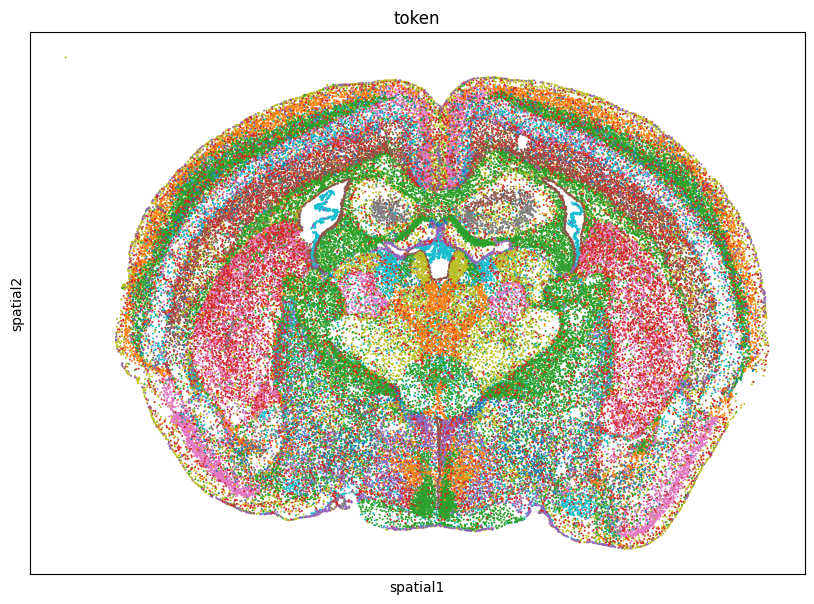

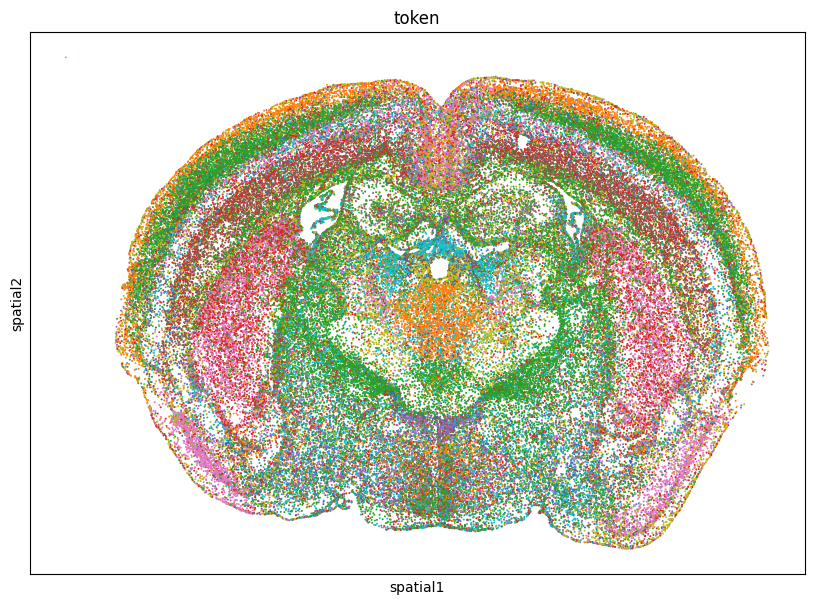

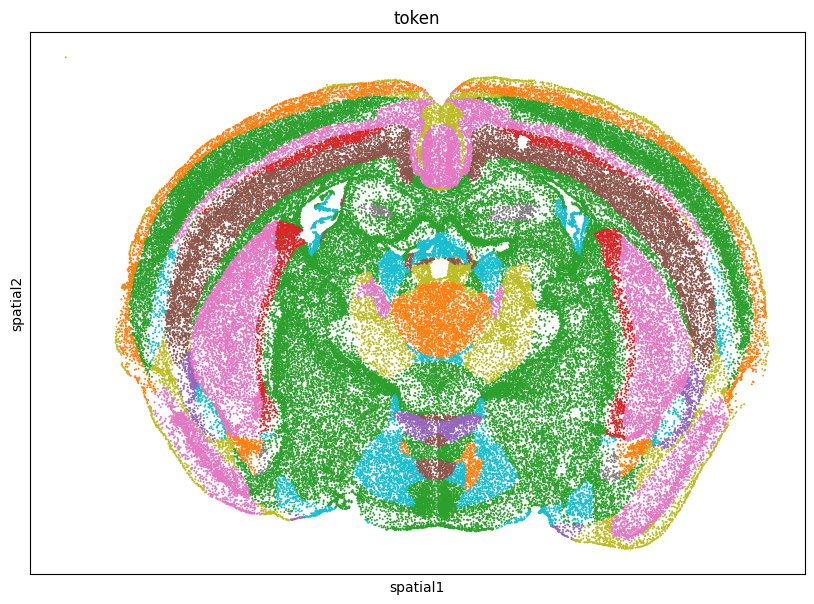

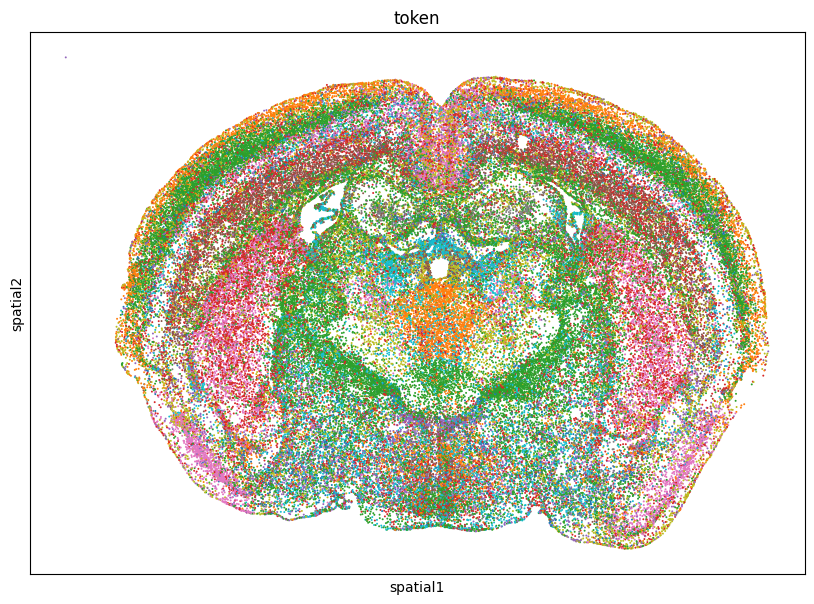

In [53]:
# import anndata as ad
# from matplotlib.pyplot import rc_context
# from metrics4 import *
# from analysis import *

# new_tissue=slices_tokenized2[43]#ad.concat(slices_tokenized2)


# device="cuda"
# xyz_samples = torch.tensor(new_tissue.obsm["aligned_spatial"], dtype=torch.float32).to(device)
# adata_argmax, _ = generate_anndata_from_samples(region_model_adpated, xyz_samples, device, sample_from_probs=False)
# adata_sampled, _ = generate_anndata_from_samples(region_model_adpated, xyz_samples, device, sample_from_probs=True)


# print(soft_accuracy(test_slice.obs["token"].to_numpy().tolist(),test_slice.obsm["aligned_spatial"],adata_sampled.obs["token"].tolist(),adata_sampled.obsm["spatial"],radius=0.05))
adata_homo=adata_sampled.copy()
adata_homo.obs["token"]=homogenized_labels

assign_shared_colors([adata_sampled,new_tissue,adata_homo,adata_argmax], color_key="token")
new_tissue.obsm["spatial"]=new_tissue.obsm["aligned_spatial"]
plot_spatial_with_palette(new_tissue, color_key="token", spot_size=0.003, figsize=(10,10))
# plot_spatial_with_palette(test_slice, color_key="entropy", spot_size=0.002, figsize=(30,30))
# plot_spatial_with_palette(adata_argmax, color_key="token", spot_size=0.001, figsize=(30,30))
plot_spatial_with_palette(adata_sampled, color_key="token", spot_size=0.003, figsize=(10,10))
plot_spatial_with_palette(adata_argmax, color_key="token", spot_size=0.003, figsize=(10,10))

plot_spatial_with_palette(adata_homo, color_key="token", spot_size=0.003, figsize=(10,10))

